# Assignment 2: Sentiment Classification Using Logistic Regression

## Programming Assignment (100 Points scaled to 40)

For this assignment we will be implementing a naive bayes baseline classifier. Additionally, we will be using pytorch to implement a binary logistic regression classifier. Our task is sentiment classification for hotel reviews. The input to your model will be a text review, and the output label is a 1 or 0 marking it as positive or negative.

We have provided a util.py file for loading the data, and some of the basic modeling. Your task is to fill in the functions below in order to train as accurate a classifier as possible!

We suggest browsing the util.py script first. Additionally, make sure to install dependencies from the provided requirements.txt file in a similar fashion to the pytorch tutorial. With your environment activated int he terminal, run:
```
pip install -r requirements.txt
```

In [ ]:
!pip install matplotlib

In [1]:
from typing import List
import spacy
import torch
import random
import sklearn
import matplotlib.pyplot as plt
import numpy as np

## Section 1: Sentiment Classification Dataset (Total: 20 Points)

The training data for this task consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [2]:
from util import load_train_data
pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Lets look at what is in the data

In [3]:
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
From the moment you walk in, you know the experience at the Westin is going to be a fantastic one. The staff behind the counter are friendly and the bellhop will take your bags to your room while you check in. Everyone is dressed nicely and act very professionally; something you expect from such a high quality hotel. The rooms are large with nice flat-screen televisions to watch while you're laying on a goose feather down comforter. The bathroom is equally as impressive with marble floors, a large back lit mirror and a walk in shower that has stone tile! The in house restaurant has a variety of delicious menu options to eat while you look out over the pool deck. Valet parking is available as well and can be called from your room so you don't have to wait! I loved this hotel and would recommend it to anyone seeking luxury and comfort during their stay.

--- Negative Example ---
When we reserved a reservation at La Quinta Hotel in Ft. Lauderdale, FL, we expected 

### Test Data ( WAIT TILL DEADLINE)

This is the test dataset that you will need to use to report the results on. This set is the unseen dataset meaning, you are not in anyway supoose to look what is in this dataset. We will release this dataset on the last day of the assignment's deadline.

In [4]:
### RUN THIS ONLY ON DEADLINE ###
# Load the test data

from util import load_test_data

# FIXME
test_datapath = "data/test-dataset.txt"
test_texts, test_labels = load_train_data(test_datapath)

TypeError: load_train_data() missing 1 required positional argument: 'negative_filepath'

### Task 1.1: Print the number of "positive" and "negative" samples (5 Points)

It is important to know the distribution of the training examples. More often than not, you will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

ones:95
zeros:94


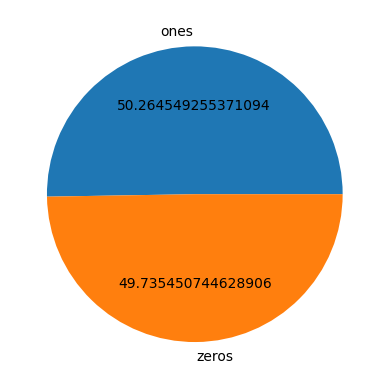

In [12]:
### ENTER CODE HERE ###

# Note since we have them in two seperate files, 
# this can also be done with bash commands
def label_distribution(labels):
    """
    TODO: Replace the line `raise NotImplementedError` with your code
    to print the labels distribution.
    """
    #raise NotImplementedError
    count1s = 0
    count0s = 0
    for i in labels:
        if i == 1:
            count1s +=1
        else:
            count0s +=1
    print(f'ones:{count1s}')
    print(f'zeros:{count0s}')
    plt.pie([count1s, count0s], labels=['ones','zeros'], autopct=str)
    plt.show()
label_distribution(all_labels)

### Task 1.2: Split Training and Development Sets (5 Points)

For the purpose of coming with the best parameters for the model you will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

Train Label Distribution:
ones:76
zeros:75


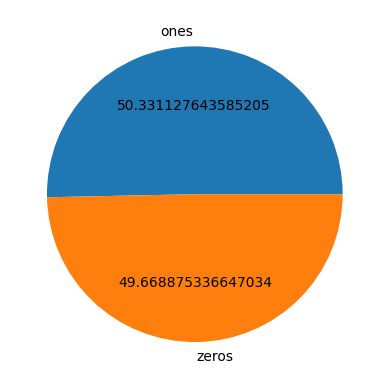

Dev Label Distribution:
ones:19
zeros:19


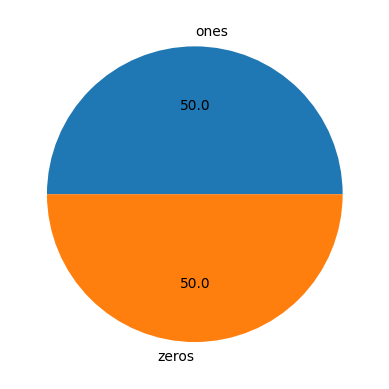

In [13]:
### ENTER CODE HERE ###

def split_dataset(texts, labels):
    """
    Split the dataset randomly into 80% training and 20% development set
    Make sure the splits have the same label distribution
    """
    split_pct = 0.8
    dataset = list(zip(all_texts, labels))
    np.random.shuffle(dataset)
    split_index = int(len(dataset) * split_pct)
    train_data = dataset[:split_index]
    test_data = dataset[split_index:]
    train_texts, train_labels = zip(*train_data)
    dev_texts, dev_labels = zip(*test_data)
    return train_texts, train_labels, dev_texts, dev_labels

train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

print('Train Label Distribution:')
label_distribution(train_labels)

print('Dev Label Distribution:')
label_distribution(dev_labels)

### Task 1.3: Evaluation Metrics (10 Points)

Implement the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [24]:
### ENTER CODE HERE ###

def accuracy(predicted_labels, true_labels):
    """
    Accuracy is correct predictions / all predicitons
    
    """
    if len(predicted_labels)!=len(true_labels):
        return 'Array size mismatch'
    pl = np.array(predicted_labels)
    tl = np.array(true_labels)
    return sum(pl == tl)/len(pl)

def precision(predicted_labels, true_labels):
    """
    Precision is True Positives / All Positives Predictions
    """
    if len(predicted_labels)!=len(true_labels):
        return 'Array size mismatch'
    pl = np.array(predicted_labels)
    tl = np.array(true_labels)
    true_positives = sum((tl == 1) & (pl == 1))
    false_positives = sum((tl == 0) & (pl == 1))
    return true_positives / (true_positives + false_positives) 

def recall(predicted_labels, true_labels):
    """
    Recall is True Positives / All Positive Labels
    """
    if len(predicted_labels)!=len(true_labels):
        return 'Array size mismatch'
    pl = np.array(predicted_labels)
    tl = np.array(true_labels)
    true_positives = sum((tl == 1) & (pl == 1))
    false_negatives = sum((tl == 1) & (pl == 0))
    return true_positives / (true_positives + false_negatives) 

def f1_score(predicted_labels, true_labels):
    """
    F1 score is the harmonic mean of precision and recall
    """ 
    precisionscore = precision(predicted_labels, true_labels)
    recallscore = recall(predicted_labels, true_labels)
    return 2*precisionscore*recallscore/(precisionscore + recallscore)

In [25]:
### DO NOT EDIT ###

em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Baselines (Total: 20 Points)

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model. You will create two baselines:

1. Random Chance
2. Naive Bayes Classifier

### Task 2.1: Random Chance Classifier (5 Points)

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [ ]:
### ENTER CODE HERE ###

def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times
    """
    from random import sample
    
    

### Task 2.2: Naive Bayes Classifier (Total: 10 Points)

In the class, Jim went over how to implement a Naive Bayes Classifier using the tokens in the training samples.
In this task, you will do the same. As a preprocessing step, you might want to remove the stop words and lemmatize/stem the words of the texts. 

### Spacy Model https://spacy.io

To tokenize the text and help extract features from text, we will use the popular spaCy model

In [ ]:
### DO NOT EDIT ###

# Initialize the spacy model
nlp = spacy.load('en_core_web_sm')

### Task 2.2.1: Play around with spacy (0 Points)

In [ ]:
### ENTER CODE HERE ###

test_string = "This is an amazing sentence"

# parse the string with spacy model
test_doc = nlp(test_string)

print('Token', 'Lemma', 'Is_Stopword?')
for token in test_doc:
    print(token, token.lemma_, token.is_stop)

### Task 2.2.2: Preprocessing (5 Points)

Remove stopwords and lemmatize the words of a text

In [ ]:
### ENTER CODE HERE ###

def pre_process(text: str) -> List[str]:
    """
    remove stopwords and lemmatize and return an array of lemmas
    """
    raise NotImplementedError
    
test_string = "This sentence needs to be lemmatized"

assert len({'sentence', 'need', 'lemmatize', 'lemmatiz'}.intersection(pre_process(test_string))) >= 3

print('All Test Cases Passed!')

### Task 2.2.3: The Naive Bayes Class (5 Points)

The standard way of implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [ ]:
### ENTER CODE HERE ###

class NaiveBayesClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.label_word_counter = {}
        self.label_words_count = {}
    
    def fit(self, texts, labels):
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        raise NotImplementedError
    
    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        raise NotImplementedError

### Task 2.3: Baseline Results  (5 Points)

Since there is not hyperparameter-tuing required for the baselines, we can use the entirety of the training set (no need to split the dataset into train and development). Report the results you achieve with the two baselines by running the following cell:

In [ ]:
### DO NOT EDIT ###

### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(dev_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, dev_labels))

In [ ]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

## Section 3: Logistic Regression on Features (Total: 60 Points)

Now let's try building a logistic regression based classifier on hand-engineered features.

The following tasks are going to be the implementation of the components required in building a Logistic Regressor.

### Task 3.0: Feature Extraction (20 points)

This is perhaps the most challenging part of this assignment. In the class, we went over how to featurize text for a classification system for sentiment analysis. In this assignment, you should implement and build upon this to accuractely classify the hotel reviews.

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". Please go through some of the datapoints and convert the signals that you think might help in identifying "sentiment" as features.

Please refer to the section in Jim's book that illustrates the process of feature engineering for this task. We have attached an image of the table below:

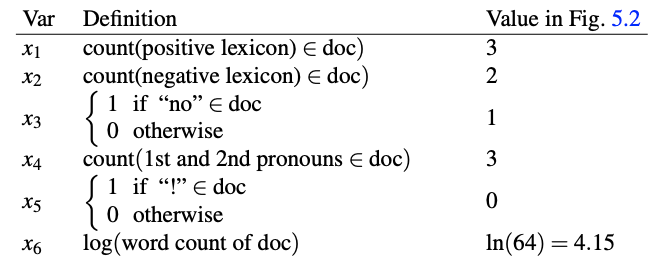

Please use the files with postive and negative words attached in the assignment: [positive_words.txt](data/poisitive-words.txt) and  [negative_words.txt](data/negative-words.txt)

In [ ]:
def make_test_feature(text: spacy.tokens.doc.Doc):
    return "happy" in [t.lemma_ for t in text]


def extract_features(text: spacy.tokens.doc.Doc):
    features = []
    # TODO: Replace this with your own feature extraction functions.
    features.append(make_test_feature(text))
    # TODO: add more features to the feature vector
    
    return features

In [ ]:
### ENTER CODE HERE ###
### DO NOT CHANGE THE SIGNATURE OF THE function THOUGH ###

def featurize_data(texts, labels):
    features = [
        extract_features(doc) for doc in nlp.pipe(texts)
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

### Task 3.0.2: Feature Scaling (10 Points)

In this task we will use the data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we need to call the following function before passing it to the classifier

#### Normalization Formula

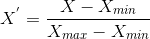

In [ ]:
### ENTER CODE HERE ###

def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
    raise NotImplementedError

## Training a Logistic Regression Classifier (Total: 30 Points)

In this section, you will implement the components needed to train the binary classifier using logistic regression

### Here we define our pytorch logistic regression classifier (DO NOT EDIT THIS)

In [ ]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        # Initialize weights. Note that this is not strictly necessary,
        # but you should test different initializations per lecture
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # We predict a number by multipling by the coefficients
        # and then take the sigmoid to turn the score as logits
        return torch.sigmoid(self.coefficients(features))

### Task 3.1: Initialize the weights. (5 Points)

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we need to try different initialization methods and compare the accuracy we achieve for the development set. In this task, implement the function that initializes the parameters to ...

In [ ]:
### ENTER CODE HERE ###

def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """
    raise NotImplementedError

Let's build a training function similar to the linear regressor from the tutorial

### Task 3.2: Logistic Loss Function (10 Points)

In [ ]:
### ENTER CODE HERE ###

def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """
    raise NotImplementedError

### Task 3.3: Create an SGD optimizer (0 Points)

We have already provided the implementation of how to create the SGD optimizer

You may try different optimizers refering to the docs provided

In [ ]:
### ENTER CODE HERE ###

def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

### Task 3.5: Converting Logits into Predictions (5 Points)

In [ ]:
### ENTER CODE HERE ###

def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
        raise NotImplementedError

### Training Function (DO NOT EDIT THIS)

In [ ]:
### DO NOT EDIT ###

from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

### Task 3.6: Train the classifier (10 Points)

Run the following cell to train a logistic regressor on your hand-engineered features.

In [ ]:
### DO NOT EDIT ###

num_epochs = 100

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

### Task 3.7: Get the predictions on the Test Set using the Trained model and print the F1 score (10 Points)

In [ ]:
### DO NOT EDIT ###

### DEV SET RESULTS

test_features, test_labels = featurize_data(dev_texts, dev_labels)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

In [ ]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

test_features, test_labels = featurize_data(test_texts, test_labels)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

## Written Assignment (60 Points)

Written assignment tests the understanding of the student for the assignment's task. We have split the writing into sections. You will need to write 1-2 paragraphs describing the sections. Please be concise.

### In your own words, describe what the task is (20 points)

Describe the task, how is it useful and an example.

### Describe your method for the task (10 points)

Important details about the implementation. Feature engineering, parameter choice etc.

### Experiment Results (10 points)

Typically a table summarizing all the different experiment results for various parameter choices

### Discussion (20 points)

Key takeaway from the assignment. Why is the method good? shortcomings? how would you improve? Additional thoughts?